In [ ]:
#Reference
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#https://towardsdatascience.com/celebrity-face-generation-with-deep-convolutional-gans-40b96147a1c9
#https://github.com/xusensun/PyTorch/blob/main/DCGAN%20Tutorial/dcgan_faces_tutorial.py

In [ ]:
!unzip 'drive/MyDrive/STAT3007/Data/archive_MMA_c3.zip' -d 'sample_data/data/'

In [ ]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
import pickle as pkl

In [ ]:
class IndexableDataset(datasets.ImageFolder):
  def __init__(self, root: str,
        transform = None):
    super().__init__(root, transform=transform,)
    self.imgs = self.samples
    self.samples_c = [[s for s in self.samples if s[1]==i] for i in range(7)]
  def __getitem__(self, index: int):
    # 0: angry, 1: disgust, 2: fear, 3: happy, 4: neutral, 5: sad, 6: surprise
    #c=random.randint(0,6)
    c=1# select one class
    path, target = random.choice(self.samples_c[c])
    #path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
      sample = self.transform(sample)
    if self.target_transform is not None:
      target = self.target_transform(target)
    return sample, target

In [ ]:
dataroot = f'sample_data/data/archive_MMA_c3/MMAFEDB_new/train/' #folder inside content/ but outside drive/ for faster loading
nc=1
dataset=IndexableDataset(
    root=dataroot,
    transform=transforms.Compose([
    transforms.Resize([48,48]) #[image_size,image_size]->resize H and W, image_size->resize W
    ,transforms.ToTensor()
    ,transforms.RandomHorizontalFlip()
    ,transforms.Grayscale(1) #reduce the channel number to 1 to make the calculation faster
    ]))

In [ ]:
dataloader=DataLoader(dataset,num_workers=0,batch_size=64,shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

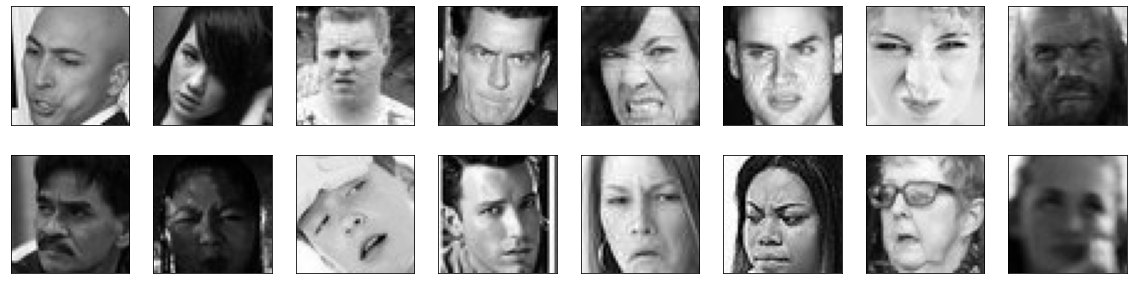

In [ ]:
def view_samples(epoch, samples, nc=3):
  fig, axes = plt.subplots(figsize=(20,5), nrows=2, ncols=8, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img=img/2+0.5
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if nc==3:
      im = ax.imshow(img.reshape((48,48,3)))
    else:
      im = ax.imshow(img.reshape((48,48)),cmap='Greys_r')
def Gshow(img): #show gray scale images
  img=img.numpy()
  img_=img.reshape(48,48) #reshape from 64*64*1 to 64*64 as imshow(cmap='gray) only takes two values
  plt.imshow(img_,cmap='gray')# 64*64
  
dataiter=iter(dataloader)
images,labels=dataiter.next()
plot_only=16 #plot only 16 images
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
  ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
  Gshow(images[idx])

In [ ]:
def weights_init(model):
  cname=model.__class__.__name__
  #print(cname.find('Conv'))
  if (cname.find('Conv')!=-1) or (cname.find('Linear')!=-1):
    #model.weight.data.normal_(0.0, 0.02)
    nn.init.xavier_normal_(model.weight.data)
    if hasattr(model, 'bias') and model.bias != None:
      model.bias.data.zero_()

class Generator(nn.Module):
  def __init__(self,z_size,n_features=512,n_channels=1):#n_features(4*4 each), was 1024 on the paper
    super(Generator,self).__init__()
    self.n_features=n_features
    self.n_channels=n_channels

    n_features1=int(n_features/2)
    n_features2=int(n_features/4)
    n_features3=int(n_features/8)
    self.fc = nn.Linear(z_size,n_features*3*3)

    self.bn1 = nn.BatchNorm2d(int(n_features1))
    self.conv1=nn.Conv2d(n_features,n_features1,kernel_size=[3,3],padding=[1,1],bias=False)
        
    self.bn2 = nn.BatchNorm2d(n_features2)
    self.conv2=nn.Conv2d(n_features1,n_features2,kernel_size=[3,3],padding=[1,1],bias=False)

    self.bn3 = nn.BatchNorm2d(n_features3)
    self.conv3=nn.Conv2d(n_features2,n_features3,kernel_size=[3,3],padding=[1,1],bias=False)
        
    self.conv4=nn.Conv2d(n_features3,self.n_channels,kernel_size=[3,3],padding=[1,1],bias=False)
  def forward(self,x):
    #[batch_size, z_size]->[batch_size, conv_dim*8*(H/16)*(W/16)]
    x=self.fc(x)# [128,100]->[128,4096]
        
    #[batch_size, conv_dim*8*(H/16)*(W/16)]->[batch_size, conv_dim*8, (H/16), (W/16)]
    x=x.view(-1,self.n_features,3,3) #[128,4096]->[128,512,4,4]
    #[batch_size, conv_dim*8, (H/16), (W/16)]->[batch_size, conv_dim*4, (H/8), (W/8)]
    x=F.relu(self.bn1(self.conv1(F.interpolate(x,[6,6])))) #[128,512,4,4]->[128,256,8,8]

    #[batch_size,conv_dim*4, (H/8), (W/8)]->[batch_size, conv_dim*2, (H/4), (W/4)]
    x=F.relu(self.bn2(self.conv2(F.interpolate(x,[12,12])))) #[128,256,8,8]->[128,128,16,16]

    #[batch_size, conv_dim*2, (H/4), (W/4)]->[batch_size, conv_dim*1, (H/2), (W/2)]
    x=F.relu(self.bn3(self.conv3(F.interpolate(x,[24,24])))) #[128,128,16,16]->[128,64,32,32]

    #[batch_size, conv_dim*1, (H/2), (W/2)]->[batch_size, num_channels, H, W]
    x=self.conv4(F.interpolate(x,[48,48])) #[128,64,32,32]->[128,1,64,64]
    out=torch.tanh(x)
    return out

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,n_features=512,n_channels=1):
    super(Discriminator,self).__init__()
    self.n_features=n_features
    self.n_channels=n_channels

    n_features1=int(n_features/2)
    n_features2=int(n_features/4)
    n_features3=int(n_features/8)
          
    self.conv1=nn.Conv2d(n_channels,n_features3,kernel_size=[4,4],stride=[2,2],padding=[1,1],bias=False)
    self.bn1=nn.BatchNorm2d(n_features3)

    self.conv2=nn.Conv2d(n_features3,n_features2,kernel_size=[4,4],stride=[2,2],padding=[1,1],bias=False)
    self.bn2=nn.BatchNorm2d(n_features2)
      
    self.conv3=nn.Conv2d(n_features2,n_features1,kernel_size=[4,4],stride=[2,2],padding=[1,1],bias=False)
    self.bn3=nn.BatchNorm2d(n_features1)

    self.conv4=nn.Conv2d(n_features1,n_features,kernel_size=[4,4],stride=[2,2],padding=[1,1],bias=False)

    self.fc=nn.Sequential(nn.Linear(n_features*3*3,n_features*3),nn.Linear(n_features*3,100),nn.Linear(100,1))
  def forward(self,x,features_only=False):
    x=F.leaky_relu(self.bn1(self.conv1(x)),0.2)#[48,48]->[24,24]
    x=F.leaky_relu(self.bn2(self.conv2(x)),0.2)#[24,24]->[12,12]
    x=F.leaky_relu(self.bn3(self.conv3(x)),0.2)#[12,12]->[6,6]
    x=F.leaky_relu(self.conv4(x),0.2)#[6,6]->[3,3]
    x=x.view(-1,self.n_features*3*3)
    if features_only:
      return x
    out=self.fc(x)
    return out

In [ ]:
z_size=100
D=Discriminator(n_features=512,n_channels=nc).to(device)
G=Generator(z_size,n_features=512,n_channels=nc).to(device)

#D.apply(weights_init),G.apply(weights_init) #comment this line if using pretrained model.

######pretrained model section######
#load pretrained model
epoch=19
G=torch.load('drive/MyDrive/training_results/G'+str(epoch)+'.pth')
D=torch.load('drive/MyDrive/training_results/D'+str(epoch)+'.pth')
G.train()
D.eval()
D.fc.train()
######################################
optim_D=optim.Adam(D.parameters(),lr=0.0001,betas=(0.5,0.999))
optim_G=optim.Adam(G.parameters(),lr=0.0001,betas=(0.5,0.999))

In [ ]:
def train(D, G, optimiD, optimiG, n_epochs, record_every=100, model_path='drive/MyDrive/models/', sample_path='drive/MyDrive/training_results/'):
  samples_save=[]
  losses=[]
  d_loss_sum=0
  g_loss_sum=0
  # 16 fixed z, each with len(z)=100, can produce 16 images
  sample_size=16
  fixed_z = torch.randn([sample_size,z_size],device=device)
  criterion_logit=nn.BCEWithLogitsLoss()
  
  for epoch in range(n_epochs):
    for batch_i, (real_images, real_labels) in enumerate(dataloader):

      batch_size=real_images.size(0)
      real_images=real_images.to(device)
      real_labels=real_labels.to(device)
      # labels
      true_labels=torch.ones(batch_size,device=device).unsqueeze(1)
      fake_labels=torch.zeros(batch_size,device=device).unsqueeze(1)
      # ========train D========
      optimiD.zero_grad()
      
      # train on real images          
      D_real_logits=D(real_images)
      d_real_loss=criterion_logit(D_real_logits, true_labels)
            
      # Generate fake images
      z=torch.randn([batch_size,z_size],device=device)
      fake_images=G(z)
      # train on fake images with label=0
      D_fake_logits=D(fake_images)
      d_fake_loss=criterion_logit(D_fake_logits, fake_labels)
            
      # sum losses and backward()
      d_loss=(d_real_loss+d_fake_loss)/2
      d_loss.backward()
      optimiD.step()

      # ========train G========
      optimiG.zero_grad()
            
      # Generate fake images
      z=torch.randn([batch_size,z_size],device=device)
      fake_images=G(z)
            
      # use D to predict on fake images 
      D_fake_logits=D(fake_images)
      g_logit_loss=criterion_logit(D_fake_logits, true_labels)
            
      # backward
      g_logit_loss.backward()
      optimiG.step()

      d_loss_sum+=d_loss.item()
      g_loss_sum+=g_logit_loss.item()
      # Print some loss stats
      if batch_i % record_every==0 and batch_i!=0:
        # append discriminator loss and generator loss
        losses.append((d_loss_sum/record_every,g_loss_sum/record_every))
        # print discriminator and generator loss
        print('Epoch [{:5d}/{:5d}] |Batch [{:5d} ~{:5d}] | AVG_D_loss: {:6.4f} | AVG_G_loss: {:6.4f}'.format(
                        epoch+1, n_epochs,batch_i-100,batch_i, d_loss_sum/record_every, g_loss_sum/record_every))
        d_loss_sum,g_loss_sum=0,0


    ## AFTER EACH EPOCH##
    with torch.no_grad():
      samples_save.append(G(fixed_z).cpu())
      #with open(sample_path+'train_samplesG_MMA_disgust'+str(epoch+1)+'.pkl', 'wb') as f: #saving MMA model without pretrained on CelebA
      with open(sample_path+'train_samplesG_MMA_disgust_pretrained'+str(epoch+1)+'.pkl', 'wb') as f: #saving MMA model with pretrained on CelebA
        pkl.dump(samples_save, f)

  return losses

In [ ]:
n_epochs=50
# call training function
losses=train(D,G,optim_D,optim_G,n_epochs=n_epochs)

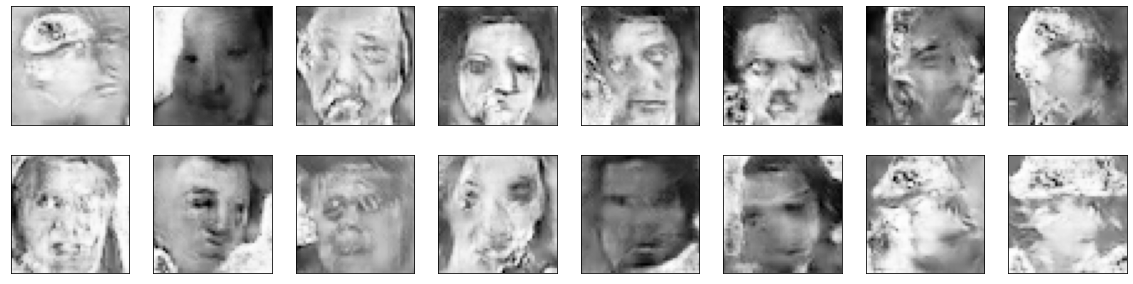

In [ ]:
with open('drive/MyDrive/training_results/train_samplesG_MMA_disgust15.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples,nc=nc)#show the last batch of stored images

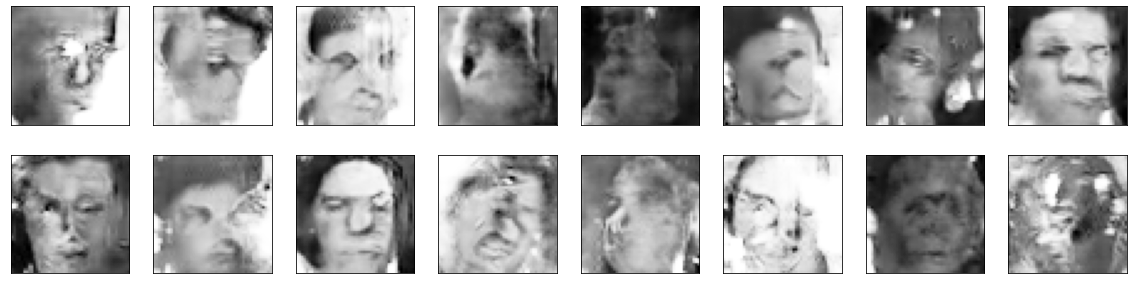

In [ ]:
with open('drive/MyDrive/training_results/train_samplesG_MMA_disgust_pretrained5.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples,nc=nc)#show the last batch of stored images